In [1]:
#!/usr/bin/env python  

import scipy
import scipy.stats as stat
import math
import numpy as np
import matplotlib.pyplot as pl
import matplotlib.axes
from scipy.optimize import curve_fit
import itertools
from astropy.table import Table
import sys

In [2]:
# # Probability Model
# 


# The value of a is the semi-amplitude of fractional variation,
# i.e. relative to mean flux.  So it should be <1 to have no
# negative-flux models.
        
def yModel(phi, f0, a):
    '''Return noiseless data given light-curve phase, mean flux, and amplitude'''
    return f0*(1+ a*np.cos(phi))

def ySimulate(phi, f0, a, sigmaNoise):
    '''Return a noisy set of observations'''
    out = yModel(phi, f0, a)
    if type(out)!=np.array:
        out += np.random.normal(loc=0.0,scale = sigmaNoise)
    else:
        out += np.random.normal(size=len(out),loc=0.0,scale = sigmaNoise)

    return out

def logProbY(phi, y, f0, a, sigmaNoise):
    '''Return log(probability) at a single phase for a measured flux y with 
    uncertainty sigmaNoise.'''
    p = -0.5*((y - yModel(phi,f0,a))/sigmaNoise)**2
    p -= 0.5*np.log((2*math.pi*sigmaNoise**2))
    return p

def marginalize(logProbY, observationList, fluxesTrue, a):
    '''Return probability of a list of observations that all have the same
    light-curve phase after marginalization over that phase.
    `logProbY` is a function evaluating a single observation/phi combo
    `observationList` is a list of observations, with each observation being
         a list or tuple of (band, flux, sigma) for each measurement.
    `fluxesTrue` is a vector of mean fluxes indexed by the band numbers
    `a` is the light curve fractional semi-amplitude.'''
 
    # Choose numbr of phi's across the range 0-2pi
    # Based on (amplitude of variation) / (noise level)
    # Pull out observed and true flux for each observation, plus
    # observational error
    band, obsFlux, sigmaNoise = (np.array(i) for i in zip(*observationList))
    trueFlux = fluxesTrue[band]
    # Make put at least 4x as many phase steps as the S/N of variation
    maxSignalToNoise = np.max(trueFlux / sigmaNoise)  ### add
    ### maxSignalToNoise = np.max(fluxesTrue / sigmaNoise)
    npts = np.ceil(maxSignalToNoise * np.abs(a)) * 4   #### no exp anymore
    npts = min(128,int(npts))
    npts = max(8,npts)
    phi = np.arange(npts) * np.pi/npts ### Only go 0-pi, not 2pi
    lp = 0
    for i in range(len(obsFlux)):  ## Change loop to be over an index
        lp += logProbY(phi, obsFlux[i], trueFlux[i], a, sigmaNoise[i] )
    lp0 = np.max(lp)
    integral = np.mean(np.exp(lp-lp0))
    return lp0 + np.log(integral)

def negLogTotalP(yData, p):
    '''Returns -log prob(data | parameters) where
    `yData` is a list of lists of observations.  Each inner list
       contains the set of observations that have a common light-curve
       phase.
    `p` is the parameter vector, which is the vector of mean fluxes
       per band with the last element being semi-amplitude `a` that
       is common to all bands.
    If `a<0`, the probability is heavily penalized so the sample will
    be rejected.'''
    # Split up the parameters into fluxes and amplitude
    fTrue = p[:-1]
    a = p[-1]
    # Return -log(P) for all points in yData vector
    logSum = 0
    for y in yData:
        logSum -= marginalize(logProbY,y,fTrue,a)
    # Heavily penalize logSum for a negative amplitude
    if p[-1] < 0:
        logSum += 100.
    return logSum
    


# # MHMC Code

class GaussianProposal:
    def __init__(self, sigma):
        '''Create a proposal distribution that is Gaussian in each parameter
        with individually specified `sigma` values in a vector.'''
        self.sigma = sigma
    def __call__(self, oldParameters):
        '''Return proposed new params given an old vector of them'''
        return np.random.normal(loc=oldParameters, scale=self.sigma)
    
def MCMC(ydata, proposal, startingParameters, iterations,
        debug = False):
    '''Run a Metropolis-Hastings chain 
    `yData` is a structure holding all data, i.e. our list of observationLists
    `proposal` is an instance of a proposal distribution class
    `startingParameters` is where the chain will begin (vector)
    `iterations` is number of desired samples.
    Returns a 2d array giving parameters of all samples of chain.
    '''
    p = np.array(startingParameters)
                    
    # keep is the chain output
    keep = np.zeros( (iterations, len(startingParameters)), dtype=float)

    #prob with starting vals
    prob = negLogTotalP(ydata,p)
    for i in range(iterations):
        # Evaluate a proposal
        pNew = proposal(p)
        probNew = negLogTotalP(ydata,pNew)  
        u = np.random.uniform()
        # Make the MH decision
        if np.log(u) < (prob-probNew):
            if debug:
                print('Accept at ',prob,probNew,u,p)
            keep[i] = pNew
            p = pNew
            prob = probNew 
        else:
            if debug:
                print('Reject at ',prob,probNew,u,pNew)
            keep[i] = p
    return keep   

def getcLen(fkeep,kmax=100):
    '''get correlation length for any 1d set of samples `fkeep`'''
    tmp = fkeep - np.mean(fkeep)
    c0 = np.mean(tmp*tmp)
    cprev = 1.
    target = np.exp(-1.)   # Look for where it drops below 1/e
    for k in range(1,kmax+1):
        c = np.mean(tmp[:-k]*tmp[k:])/ c0
        if c<=target:
            # Interpolate correlation linearly to the target point
            frac = (cprev-target) / (cprev-c)
            return k-1. + frac
        else:
            cprev = c
    # Get here if we did not reach 1/e
    return float(kmax)


# ## Function to give starting points and proposal sigmas

def mcmcHints(yData):
    '''Estimate the mean fluxes per band, uncertainty on them, 
    and the minimum detectable fractional amplitude of variation'''
    # Ignoring same-night stuff so just concatenate all observations
    allObs = list(itertools.chain(*yData))
    bb = np.array([obs[0] for obs in allObs])
    flux = np.array([obs[1] for obs in allObs])
    sig  = np.array([obs[2] for obs in allObs])
    
    bands = np.unique(bb)
    fluxEst = np.zeros(len(bands),dtype=float)
    fluxSigma = fluxEst.copy()
    fisherAA = 0.  # Accumulate Fisher information on fractional variance
    
    for i,b in enumerate(bands):
        use = bb==b
        wt = sig[use]**-2
        fMean = np.sum(flux[use]*wt) / np.sum(wt)
        # Iterate once more putting a nominal light curve variance
        # of a few percent, to avoid overweighting
        wt = 1/(sig[use]**2 + (0.02*fMean)**2)
        fMean = np.sum(flux[use]*wt) / np.sum(wt)
        fluxEst[i] = fMean
        fluxSigma[i] = np.sum(wt)**-0.5
        
        # Get contribution to variation information
        fisherAA += 2.*np.sum((fMean*fMean*wt)**2)
    
    # Now convert the Fisher information on variance into
    # a sigma for amplitude
    aSigma = fisherAA**(-0.25)
    return fluxEst, fluxSigma, aSigma

class LightCurveTable:
    def __init__(self, tab):
        '''A class that will build an observation list from tabular data.'''
        nominalRange = 30.  # All distances transformed to this value
        self.tab = tab
        # Keep track of which entries are valid
        self.use = np.ones(len(tab), dtype=bool)
        # Don't use any with exactly zero flux
        self.use = np.logical_and(self.use, tab['FLUX']!=0.)
        self.changed = True  # status flag whenever data change
        
    def getRows(self):
        # Return time-ordered list of rows of table in use for fits
        rows = np.where(self.use)[0]
        tdb = self.tab['TDB'][rows]
        order = np.argsort(tdb)
        return rows[order]
    
    def clip(self,row):
        '''Mark a row as unusable'''
        self.use[row] = False
        self.changed = True
        return
    
    def unclip(self,row):
        '''Mark a row as usable'''
        self.use[row] = True
        self.changed = True
        return
    
    def setObsList(self):
        ''' Set up observation list, band dictionary, and DOF'''
        if not self.changed:
            # Already current
            return
        rows = self.getRows()

        # Begin loop exercised while clipping
        # Read the stuff we need
        nObs = len(rows)
        expnum = self.tab['EXPNUM'][rows]
        flux = self.tab['FLUX'][rows]
        sigma = self.tab['FLUX_ERR'][rows]
        band = self.tab['BAND'][rows]
        tdb = self.tab['TDB'][rows]

        # Rescale flux and sigma to nominal range
        rangeFactor = (self.tab['RANGE'][rows]*self.tab['SOLARD'][rows]/nominalRange**2)**2
        flux *= rangeFactor
        sigma *= rangeFactor

        # Make an array marking end of each burst of exposures
        maxDiffTDB = 1./(24*365.)  # skip in time that triggers new burst: 1 hr
        endOfBurst = np.ones(nObs, dtype=bool)
        endOfBurst[:-1] = tdb[1:]-tdb[:-1] > maxDiffTDB

        # Assign a number to each band
        bb = np.unique(band)
        self.b2n = {b:i for i,b in enumerate(bb)}

        # Build structure holding photometry
        self.yData = []
        burst = []
        self.dof = nObs - len(bb)
        for i in range(nObs):
            obs = (self.b2n[band[i]], flux[i], sigma[i])
            burst.append(obs)
            if endOfBurst[i]:
                self.yData.append(burst)
                self.dof -= 1
                burst = []
        
        self.changed = False
        return 
    
    def __call__(self, params):
        ''' Return -log(P(data | params)), where params are band fluxes and LC semi-amplitude'''
        self.setObsList()
        return negLogTotalP(self.yData, params)
    
    def optimize(self, pStart):
        ''' Return -log P(pOpt), pOpt, DOF for pOpt that minimizes former, using pStart'''
        out = minimize(self, pStart)
        return out['fun'],out['x'], self.dof

    def optimize2(self, a, flux):
        out = minimize(self,np.append(flux,a))
        return out['fun']

In [3]:
def processLC(tab, name, nIter=50000, clipThreshold=3.):
    '''Run MCMC on photometry in the table.  A FITS table with
    thinned samples will be written to a file, and diagnostic plots
    to another file, both keyed by `name`.  Diagnostic 
    summaries printed to stdout.
    
    `clipThreshold` specifies number of sigma beyond light-curve
    extremes where data points will be clipped.
    
    `nIter` is number of MCMC iterations to draw.  1/4 will be
    discarded as burn-in.
    '''
    nominalRange = 30.
    magZero = 30.
    
    # Put rows into time order, skipping zero-flux entries
    rows = np.where(tab['FLUX']!=0.)[0]
    tdb = tab['TDB'][rows]
    order = np.argsort(tdb)
    rows = rows[order]

    print('#------ Object',name)
    while (len(rows)>6):
        # Begin loop exercised while clipping
        # Read the stuff we need
        nObs = len(rows)
        expnum = tab['EXPNUM'][rows]
        flux = tab['FLUX_SN'][rows]
        sigma = tab['FLUX_ERR_SN'][rows]
        band = tab['BAND'][rows]
        tdb = tab['TDB'][rows]

        # Rescale flux and sigma to nominal range
        rangeFactor = (tab['RANGE'][rows]*tab['SOLARD'][rows]/nominalRange**2)**2
        flux *= rangeFactor
        sigma *= rangeFactor

        # Make an array marking end of each burst of exposures
        maxDiffTDB = 1./(24*365.)  # skip in time that triggers new burst: 1 hr
        endOfBurst = np.ones(nObs, dtype=bool)
        endOfBurst[:-1] = tdb[1:]-tdb[:-1] > maxDiffTDB

        # Assign a number to each band
        bb = np.unique(band)
        b2n = {b:i for i,b in enumerate(bb)}

        # Build structure holding photometry
        yData = []
        burst = []
        for i in range(nObs):
            obs = (b2n[band[i]], flux[i], sigma[i])
            burst.append(obs)
            if endOfBurst[i]:
                yData.append(burst)
                burst = []

         # Now create the proposal distribution.  
        # Use the helper function above
        startF, sigmaF, sigmaA = mcmcHints(yData)
        # set proposal sigmas to ~1/4 of estimated uncertainties
        sigmaParameters = np.append(sigmaF, sigmaA)*0.25
        proposal = GaussianProposal(sigmaParameters)

        # Make a guess to start the chain, with `a` at its
        # minimal detectable value.
        startParameters = np.append(startF, sigmaA)
        
        # Run the MCMC, discard burn-in, thin chain
        burn = 4
        keep = MCMC(yData,proposal,startParameters,nIter) 
        keep = keep[nIter//burn:,:]
        
        acceptance = np.mean(keep[:-1,-1]!=keep[1:,-1])
        thin = getcLen(keep, kmax=100)
        keep = keep[::int(np.ceil(thin)),:]
        
        print('# nObs {:3d} acceptance {:.3f} correlation {:.1f}'.format(nObs,
                                                                        acceptance,
                                                                        thin))
        # Now check for outlier data
        pmean = np.mean(keep, axis=0)
        f0 = np.array([pmean[b2n[b]] for b in band])
        df = np.abs(flux/f0 - 1.)
        nsig = np.maximum(0., (df-pmean[-1])/(sigma/f0))
        worst = np.argmax(nsig)
    
        if nsig[worst] > clipThreshold:
            # Clip the bad point from data and try again
            print("# Clip {:s} {:06d} f/f0= {:.3f} +- {:.3f} LCA {:.3f} nSigma {:.2f}".format(                      name, expnum[worst], flux[worst]/f0[worst], sigma[worst]/f0[worst], 
                     pmean[-1],nsig[worst])  )
            # Remove from table:
            good = np.ones(nObs, dtype=bool)
            good[worst] = False
            rows = rows[good]
        else:
            # Log result
            print("# Worst {:s} {:06d} {:s} f/f0= {:.3f} +- {:.3f} LCA {:.3f} nSigma {:.2f}".format(                  name, expnum[worst], band[worst], flux[worst]/f0[worst], sigma[worst]/f0[worst], 
                 pmean[-1],nsig[worst]) )
            break
        
    # Quit if no useful fit at end
    if (len(rows)<=6):
        print("### Insufficient data")
        return
    
    # Make a plot
    pl.figure(figsize=(8,10))
    if 'g' in b2n and 'r' in b2n:
        gr = -2.5*np.log10(keep[:,b2n['g']]/keep[:,b2n['r']])
    else:
        gr = None
    if 'r' in b2n and 'i' in b2n:
        ri = -2.5*np.log10(keep[:,b2n['r']]/keep[:,b2n['i']])
    else:
        ri = None
    if 'r' in b2n and 'z' in b2n:
        rz = -2.5*np.log10(keep[:,b2n['r']]/keep[:,b2n['z']])
    else:
        rz = None
    if 'r' in b2n:
        Hr = magZero - 2.5*np.log10(keep[:,b2n['r']]) - 10*np.log10(nominalRange)
    else:
        Hr = None

    pl.subplot(321)
    pl.plot(keep[:,-1],'ro')
    pl.grid()
    pl.xlabel('Sample')
    pl.ylabel('LC amplitude')
    pl.ylim(-0.1,0.7)

    pl.subplot(322)
    h = pl.hist(keep[:,-1],range=(0,1.),bins=100)
    pl.grid()
    pl.xlabel('LC amplitude')

    pl.subplot(323)
    if Hr is not None:
        pl.plot(Hr,'ro')
    pl.ylabel('H_r')
    pl.xlabel('Sample')
    pl.grid()

    pl.subplot(324)
    if gr is not None:
        h = pl.hist(gr,bins=45,range=(-0.2,1.3),histtype='step',color='b',                 label='g-r {:.2f}'.format(np.std(gr)))
    if ri is not None:
        h = pl.hist(ri,bins=45,range=(-0.2,1.3),histtype='step',color='g',                 label='r-i {:.2f}'.format(np.std(ri)))
    if rz is not None:
        h = pl.hist(rz,bins=45,range=(-0.2,1.3),histtype='step',color='r',                 label='r-z {:.2f}'.format(np.std(rz)))
    pl.grid()
    pl.legend()
    pl.xlabel('Mag')

    pl.subplot(313)
    # Plot the fluxes vs time.  Go back and plot the full table, and draw circles
    # around the ones that have been dropped.
    # Also clip to a display range
    ylims = (-0.1, 1.8)
    rangeFactor = (tab['RANGE']*tab['SOLARD']/nominalRange**2)**2
    ff = tab['FLUX']*rangeFactor
    df = tab['FLUX_ERR']*rangeFactor
        
    clipped = np.ones(len(tab), dtype=bool)
    clipped[rows] = False
    for b,c in zip('griz','mgrk'):
        if b not in b2n:
            continue
        use = tab['BAND']==b
        f0 = np.mean(keep[:,b2n[b]])
        pl.errorbar(tab['TDB'][use],
                    ff[use]/f0,
                    yerr=df[use]/f0,
                    color=c,marker='^',ls='none',label=b)
        pl.plot(tab['TDB'][use],np.clip(ff[use]/f0, *ylims),
                    color=c,marker='^',ls='none',label=None)
        # Plot red X over clipped points
        mark = np.logical_and(use, clipped)
        pl.plot(tab['TDB'][mark],np.clip(ff[mark]/f0, *ylims),
                    color='r',marker='x',ms=12,ls='none',label=None)
    pl.ylim(*ylims)
    pl.grid()
    pl.legend()
    pl.xlabel('TDB')
    pl.ylabel('Relative flux')

    pl.suptitle('Object {:s}'.format(name))
    pl.savefig('results_{:s}.pdf'.format(name))

    # Save samples
    data  = []
    names = ['g','r','i','z','Y']
    for b in names:
        if b in b2n:
            data.append(keep[:,b2n[b]])
        else:
            data.append(np.zeros_like(keep[:,0]))
    # Add a column with the object id
    data.append( np.array([name]*keep.shape[0]) )
    names.append('id')
    out = Table(data=data, names=names)
    out.write('results_{:s}.fits'.format(name), overwrite=True)
    
    # Output results - H, colors, ampl
    vals = [name]
    for v in Hr, gr, ri, rz, keep[:,-1]:
        if v is None:
            vals.append(0.)
            vals.append(0.)
        else:
            vals.append(np.mean(v))
            vals.append(np.std(v))
            
    print("{:s} {:.2f} +- {:.2f} {:.2f} +- {:.2f} {:.2f} +- {:.2f} {:.2f} +- {:.2f} {:.2f} +- {:.2f}".format(                                                                                            *vals))

    return yData, keep, b2n, rows

In [38]:
tab  = Table.read('y6_tno_photometry.fits')
tab.columns

<TableColumns names=('EXPNUM','FLUX','FLUX_ERR','MAG','MAG_ERR','BAND','FLUX_SN','FLUX_ERR_SN','MAG_SN','MAG_ERR_SN','ORBITID','CCDNUM','CHISQ','MAG_CATALOG','OBJECTID','PHASE','PHASEPA','RANGE','RESIDUAL','SN','SOLARD','TDB','RA','DEC','MPC')>

In [39]:
tab = tab[tab['ORBITID']==28]
bad = np.isin(tab['EXPNUM'],[242773,243580,257492,572271])
tab = tab[np.logical_not(bad)]
print(tab['EXPNUM','FLUX_SN','BAND','TDB'])

EXPNUM      FLUX_SN       BAND        TDB        
------ ------------------ ---- ------------------
238105 1749.1998928825003    Y 13.729827358178863
231956  449.9688391887441    g 13.688549758831028
677356  1208.260340813081    z  17.70245508583306
593826  694.4665796021372    Y  16.88068378609328
229734  379.1601049503909    g 13.669717915493305
590633 1546.2652784869592    Y   16.8506301965813
240701  553.6316545753242    g 13.753879489940934
243558 1078.5842092902017    i 13.781468938511596
247909  561.9793825687802    g  13.82491791666697
257490 434.19255888258135    g  13.89356325182008
   ...                ...  ...                ...
590632 1243.9968244081153    z 16.850627128947526
589783 444.97833188089874    g  16.84507939462744
589782 1181.8443257700962    i 16.845075614695723
378515  872.8320647043286    z 14.876293520235764
573467 403.42508557917245    Y  16.69458219441465
589781   845.970088863998    r 16.845071865948338
569945  431.9739409411815    g  16.66767473592921


In [40]:
tab.sort('EXPNUM')
for row in tab:
    scale = (row['SOLARD']*row['RANGE']/900)**2
    print('{:6d} {:s} {:7.4f} {:6.1f} +- {:4.1f} '.format(\
    row['EXPNUM'],row['BAND'],row['TDB'],row['FLUX_SN']*scale,row['FLUX_ERR_SN']*scale))


229734 g 13.6697  825.4 +- 125.4 
231956 g 13.6885  976.3 +- 164.1 
238105 Y 13.7298 3777.4 +- 1095.0 
240701 g 13.7539 1194.3 +- 146.3 
243558 i 13.7815 2327.6 +- 200.5 
247909 g 13.8249 1217.6 +- 157.4 
257490 g 13.8936  953.9 +- 95.2 
257493 i 13.8936 2143.3 +- 159.5 
259335 g 13.9182  434.6 +- 140.0 
349372 z 14.6279 2220.4 +- 413.3 
371738 r 14.8192 1590.0 +- 197.5 
372563 i 14.8247 2302.5 +- 215.6 
377002 r 14.8655 1828.9 +- 129.2 
377746 z 14.8708 1901.2 +- 371.7 
377747 Y 14.8708 2610.0 +- 1329.0 
378515 z 14.8763 1888.9 +- 360.2 
490647 r 15.8483 1551.0 +- 129.1 
490648 i 15.8483 2198.8 +- 197.8 
490649 g 15.8483 1021.2 +- 106.0 
569943 i 16.6677 2239.6 +- 208.9 
569944 r 16.6677 1849.2 +- 128.8 
569945 g 16.6677  916.2 +- 90.8 
573467 Y 16.6946  851.1 +- 1172.6 
589781 r 16.8451 1782.4 +- 111.9 
589782 i 16.8451 2490.0 +- 185.7 
589783 g 16.8451  937.5 +- 97.8 
590632 z 16.8506 2623.3 +- 418.9 
590633 Y 16.8506 3260.7 +- 1415.1 
593775 z 16.8805 1776.1 +- 338.8 
593826 Y 16.8

#------ Object test28
# nObs  31 acceptance 0.763 correlation 100.0
# Clip test28 259335 f/f0= 0.468 +- 0.151 LCA 0.066 nSigma 3.08
# nObs  30 acceptance 0.748 correlation 100.0
# Worst test28 247909 g f/f0= 1.245 +- 0.161 LCA 0.045 nSigma 1.25
test28 7.14 +- 0.04 0.61 +- 0.06 0.30 +- 0.05 0.21 +- 0.09 0.04 +- 0.03


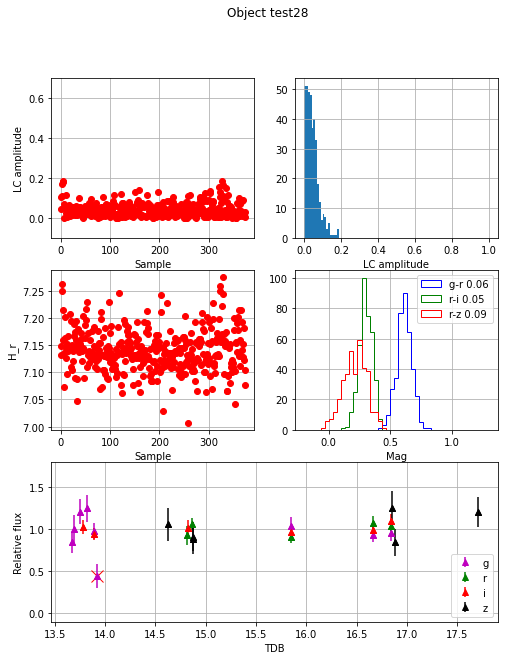

In [41]:
out = processLC(tab,'test28')

In [22]:
out

([[(1, 1849.2253580030979, 336.6797597373767)],
  [(1, 1064.9228587538155, 401.5575823269763)],
  [(0, -3435.663096152552, 4081.5112227828795)],
  [(1, 1833.8830752108427, 343.15518901032806)],
  [(0, 4155.476148169629, 4981.295693842574)],
  [(1, 944.5392936288752, 333.39143748400124),
   (1, 1754.480481616999, 327.2324196508114)],
  [(1, 1666.0782156933517, 268.0803811627349)],
  [(1, 1932.3036632872431, 276.19671668769286)],
  [(0, 9028.829541989762, 3750.9098332085264)],
  [(0, 4338.385490013115, 4343.133405982744)],
  [(2, 5437.581267485125, 557.8492046236876)],
  [(3, 2145.9702374811636, 310.7885124755412)],
  [(2, 4267.137584792714, 541.1269190258179)],
  [(2, 4991.536026752277, 546.9905622706268),
   (4, 6421.901925300878, 952.1534638189036)],
  [(4, 5864.677338643031, 948.8911506241825)],
  [(4, 5826.255494320089, 1281.7841413960095)],
  [(2, 3400.128278994967, 472.72214245563754),
   (3, 1718.138811927624, 283.5096556271922),
   (4, 3867.5598734527425, 698.9520922370666)],
  

In [23]:
np.mean(out[1],axis=0)

array([4.33046485e+03, 1.37245927e+03, 4.33065089e+03, 2.77244453e+03,
       5.60710238e+03, 2.72211788e-01])

In [24]:
nick = np.load('TNOrunTest20/Chain Output Object 19.npz')
print(np.mean(nick['arr_0'],axis=0))
nick['arr_1']


[1.17571879e+03 1.83878789e+03 1.93437122e+03 2.31060175e+03
 1.33574922e+03 2.96796353e-01]


array([1.17571879e+03, 1.83878789e+03, 1.93437122e+03, 2.31060175e+03,
       1.33574922e+03, 2.96796353e-01])

#------ Object 062
# nObs  39 acceptance 0.824 correlation 100.0
# Worst 062 572675 g f/f0= 0.206 +- 0.075 LCA 0.677 nSigma 1.56
062 6.16 +- 0.07 1.12 +- 0.10 0.41 +- 0.05 0.65 +- 0.08 0.68 +- 0.03


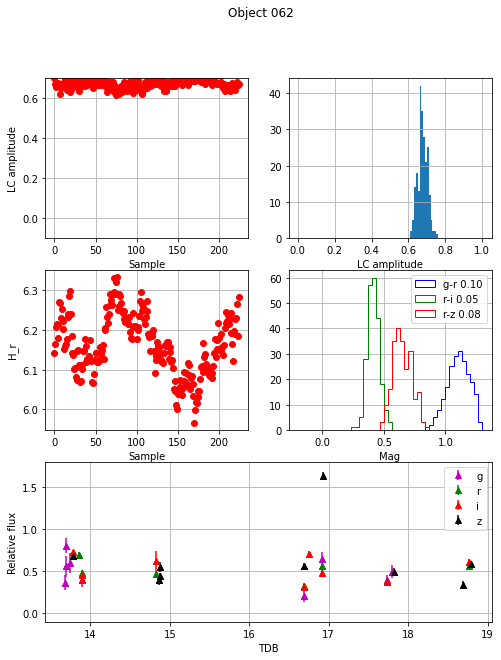

In [60]:
tab = Table.read('y6_timeseries.fits')
id = 62
objtab = tab[tab['ORBITID']==id]
##objtab = objtab[objtab['EXPNUM']!=599722]
yData, keep, b2n, rows = processLC(objtab,'{:03d}'.format(id),nIter=30000, clipThreshold=2.9)

In [19]:
## !!! Try finding outliers from least-likely burst of observations
nominalRange = 30.
#Split output into high/low-a halves, get mean p for each
amed = np.median(keep[:,-1])
top = keep[:,-1] > amed
ptop = np.mean(keep[top,:],axis=0)
pbot = np.mean(keep[~top,:],axis=0)
pmean = np.mean(keep,axis=0)
pulls = []
for i in rows:
    rangeFactor = (objtab['RANGE'][i]*objtab['SOLARD'][i]/nominalRange**2)**2
    flux = objtab['FLUX'][i]*rangeFactor
    sigma =objtab['FLUX_ERR'][i] * rangeFactor
    b = objtab['BAND'][i]
    f0 = pmean[b2n[b]]
    obs = [(b2n[b], flux, sigma)]
    pull = marginalize(logProbY, obs, ptop[:-1], ptop[-1]) - \
         marginalize(logProbY, obs, pbot[:-1], pbot[-1])
    pulls.append(pull)
    print(objtab['EXPNUM'][i], b, "{:06.3f} f/f0 = {:.3f}+-{:.3f} pull {:+.3f}".format(\
        objtab['TDB'][i],flux/f0, sigma/f0, pull))

231534 g 13.686 f/f0 = 0.682+-0.159 pull +0.046
231923 g 13.688 f/f0 = 1.041+-0.238 pull -0.114
232847 g 13.694 f/f0 = 1.500+-0.167 pull +0.157
233093 Y 13.696 f/f0 = 1.338+-0.766 pull +0.013
238927 g 13.740 f/f0 = 1.114+-0.231 pull -0.109
243501 z 13.781 f/f0 = 1.419+-0.078 pull +0.181
243513 i 13.781 f/f0 = 1.383+-0.051 pull +0.137
251784 r 13.853 f/f0 = 1.324+-0.064 pull -0.116
257226 g 13.891 f/f0 = 0.733+-0.148 pull -0.032
257227 r 13.891 f/f0 = 0.906+-0.062 pull -0.159
257228 i 13.891 f/f0 = 0.878+-0.067 pull -0.177
257471 i 13.893 f/f0 = 0.752+-0.058 pull -0.329
372121 i 14.822 f/f0 = 1.189+-0.221 pull -0.086
372128 r 14.822 f/f0 = 0.887+-0.077 pull -0.177
377004 Y 14.866 f/f0 = 1.288+-0.602 pull +0.010
377380 z 14.868 f/f0 = 0.816+-0.121 pull -0.153
377765 z 14.871 f/f0 = 0.918+-0.083 pull -0.161
378491 z 14.876 f/f0 = 1.137+-0.114 pull -0.136
572673 r 16.689 f/f0 = 0.612+-0.063 pull +0.592
572674 i 16.689 f/f0 = 0.592+-0.067 pull +0.818
572675 g 16.689 f/f0 = 0.383+-0.140 pull

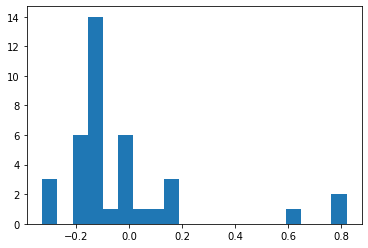

In [21]:
h = pl.hist(pulls,bins=20)

In [76]:
from scipy.optimize import minimize, minimize_scalar

In [25]:
class func:
    def __init__(self,yData):
        self.y = yData
    def __call__(self,p):
        return negLogTotalP(self.y, p)
    
ff = func(yData)

In [26]:
out = minimize(ff, pmean)

In [27]:
out

      fun: 287.67315327050324
 hess_inv: array([[ 7.65421657e+02,  2.50572916e+02, -1.51589590e+02,
        -6.71571972e+02,  1.15479811e+02, -3.13994647e-02],
       [ 2.50572916e+02,  3.41697795e+03,  1.53048373e+01,
        -2.20147461e+02, -9.14605851e+01, -1.49035601e-02],
       [-1.51589590e+02,  1.53048373e+01,  1.70087205e+03,
        -1.44084191e+03, -2.16881114e+02, -1.08659947e-01],
       [-6.71571972e+02, -2.20147461e+02, -1.44084191e+03,
         2.07311389e+03,  7.85999820e+01,  1.35475808e-01],
       [ 1.15479811e+02, -9.14605851e+01, -2.16881114e+02,
         7.85999820e+01,  4.56026412e+01,  9.16720789e-03],
       [-3.13994647e-02, -1.49035601e-02, -1.08659947e-01,
         1.35475808e-01,  9.16720789e-03,  6.45705467e-04]])
      jac: array([ 0.00000000e+00, -1.52587891e-05, -7.62939453e-05, -6.10351562e-05,
        1.90734863e-05, -3.66210938e-04])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 616
      nit: 58
     njev: 8

In [28]:
out['x']

array([2.20014649e+03, 8.11351639e+02, 3.26891031e+03, 2.22921827e+03,
       3.72797032e+03, 3.71785164e-01])

In [92]:
# Use the helper function above
id = 62
objtab = tab[tab['ORBITID']==id]
data = LightCurveTable(objtab)
data.setObsList()
startF, sigmaF, sigmaA = mcmcHints(data.yData)
pStart = np.append(startF, 0.3)


In [62]:
neglogp, pBest, dof = data.optimize(pStart)
print(neglogp,pBest)

319.99195710131903 [1.35880037e+03 1.43641812e+03 6.07476110e+03 4.14406622e+03
 7.59551873e+03 6.60859951e-01]


doing 30
doing 23
doing 12
doing 31
doing 13
doing 2
doing 39
doing 1
doing 7
doing 15
doing 4
doing 27
doing 22
doing 10
doing 29
doing 26
doing 8
doing 35
doing 32
doing 33
doing 36
doing 25
doing 28
doing 6
doing 21
doing 18
doing 0
doing 5
doing 11
doing 17
doing 16
doing 38
doing 34
doing 24
doing 14
doing 19
doing 20
doing 9
doing 37
27


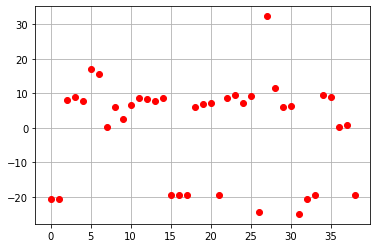

In [63]:
dlogp = []
aout = []
for i in data.getRows():
    print('doing',i)
    data.clip(i)
    data.setObsList()
    out = data.optimize(pStart)
    dlogp.append(neglogp - out[0])
    aout.append(out[1][-1])
    data.unclip(i)
    
pl.plot(dlogp, 'ro')
pl.grid()
print(np.argmax(dlogp))

In [64]:
tdb = objtab['TDB'][data.getRows()]

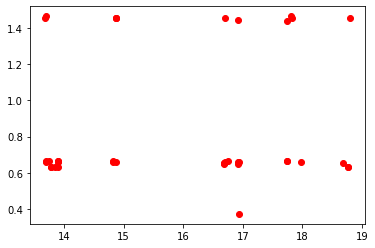

In [65]:
pl.plot(tdb,aout,'ro')

In [49]:
dlogp

[36.93967713122305,
 37.21932704060782,
 37.51345093024588,
 38.340114425775425,
 37.282507145391776,
 12.406043778969604,
 12.019885811834456,
 38.5021170432849,
 5.784250072348641,
 6.592900296713481,
 6.833206668437015,
 38.07108883124795,
 9.014134335409665,
 8.745834021481414,
 38.250753607306024,
 38.3643021795159,
 38.57132399043735,
 38.89256500445987,
 35.67655757038028,
 6.776226817955035,
 36.85664123079505,
 38.927440362400716,
 38.28448163959786,
 38.89356036769584,
 6.351203977344369,
 7.1215220167624125,
 9.243944909496463,
 44.63015612223967,
 38.05785118926889,
 6.959912277002218,
 6.645939044774366,
 6.480085514210373,
 37.10814743463072,
 38.76266329148183,
 39.039386115922184,
 38.324986312960334,
 8.693757692179247,
 8.961363433023735,
 38.95902625683351]

In [66]:
class fluxOpt:
    def __init__(self,data, a):
        self.a = a
        self.data = data
    def __call__(self,flux):
        p = np.append(flux, a)
        return self.data(p)


In [95]:
n = 5
#data.clip(n)
data.setObsList()
startF, sigmaF, sigmaA = mcmcHints(data.yData)
minimize_scalar(data.optimize2, bounds=(0.,0.9), method='bounded',args=(startF,))

     fun: 319.9919556016563
 message: 'Solution found.'
    nfev: 24
  status: 0
 success: True
       x: 0.3437694101250946

In [99]:
for a in np.arange(0,0.91,0.05):
    ff = fluxOpt(data,a)
    out = minimize(ff, startF)
    startF = out['x']
    print("{:.2f} {:.4f} ".format(a,out['fun']), out['x'])

0.00 723.1096  [2180.48318218  710.26385827 3218.99067626 2049.62930286 4900.13897931]
0.05 675.2207  [2173.71987567  722.58021105 3241.90901265 2075.8759499  5026.5932069 ]
0.10 617.7228  [2031.33308734  736.92284821 3263.89754175 2106.83917197 5220.09597812]
0.15 564.9961  [1958.24063991  755.36411806 3295.57716291 2152.1014536  5414.57169446]
0.20 520.3638  [1881.64444807  774.33852067 3338.72996843 2194.98034341 5625.99615303]
0.25 482.0428  [1876.82069939  821.51577953 3432.92766543 2257.23426792 5795.26184085]
0.30 446.3474  [1855.98191694  823.17133841 3632.69730879 2316.42072128 6271.47605361]
0.35 415.6266  [1673.89096247  851.6207596  3824.574565   2428.39036054 6608.6226772 ]
0.40 387.7155  [1612.77071253  890.02667393 4123.12746132 2639.88701279 6931.72346416]
0.45 363.7146  [1554.6735896   938.8378295  4438.55191916 2860.50160675 7210.60631063]
0.50 344.8753  [1523.93736415 1019.06640021 4786.43258114 3112.90843735 7423.40050171]
0.55 331.3743  [1487.80033894 1139.87361478

In [98]:
data.b2n

{'Y': 0, 'g': 1, 'i': 2, 'r': 3, 'z': 4}

# Non-sinusoidal light curve
Using Lacerda et al 2014 light curve for 2003 SQ137, let's see how the algorithm based on sinusoids retrieves a peak-to-peak amplitude for a very non-sinusoidal light curve.

In [3]:
# Try to copy the light curve from Lacerda Fig 1 - (phase,mag) data
from scipy.interpolate import interp1d

points = np.array(((0, 0.5),(0.06,0.75), (0.2, 0.2), (0.25,0.1), (0.3, 0.), (0.35,0.05), (0.4,0.1),
(0.5,0.5),(0.6,0.85), (0.65,0.45), (0.7,0.35), (0.8,0.1),(0.82,0.05),(0.9,0.1),(1.0,0.5)))

lcfunc = interp1d(points[:,0],points[:,1],kind='linear')


(0.9, -0.02)

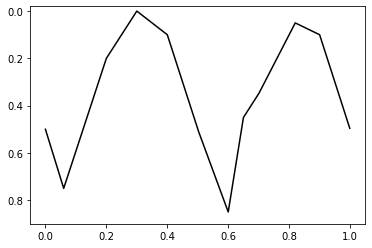

In [4]:
x = np.arange(0,1,0.001)
pl.plot(x,lcfunc(x),'k-')
pl.ylim(0.9,-0.02)

Text(0, 0.5, 'Max-likelihood A')

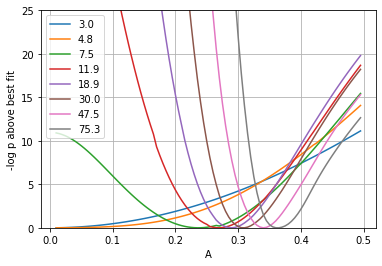

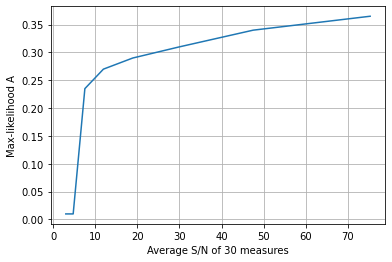

In [12]:
# See what best-fit sinusoidal amplitude of well-sampled light
# curve is, as a function of typical S/N

sn = []
bestA = []
for peakflux in 10**(np.arange(0.6,2.01,0.2)):
    # Make a fake obs list
    obslist = [[(0,peakflux* 10**(-0.4*lcfunc(phi)), 1.)] for phi in np.arange(0.,1.,0.03)]
    #obslist = [[(0,peakflux* (1+0.2*np.sin(2*np.pi*phi)), 1.)] for phi in np.arange(0.,1.,0.03)]
    f0 = np.mean([obs[0][1] for obs in obslist])
    a = np.arange(0.01,0.5,0.005)
    p = []
    for aa in a:
        params = np.array([f0,aa])
        p.append(negLogTotalP(obslist,params))
    sn.append(f0/1.)
    bestA.append(a[np.argmin(p)])
    pl.plot(a,p-np.min(p),label='{:.1f}'.format(f0))
pl.ylim(0,25)
pl.grid()
pl.legend()
pl.xlabel('A')
pl.ylabel('-log p above best fit')

pl.figure()
pl.plot(sn,bestA)
pl.grid()
pl.xlabel("Average S/N of 30 measures")
pl.ylabel("Max-likelihood A")